
|Version|Date|Description|
|--|--|--|
|0.1|2024-11-29|Initial|
|0.2|2024-12-03|Updated the model parameter by increasing the no.of stack LSTM layer from 1 to 3|
|0.3|2024-12-04|Change the sequence of train_test_split and normalization flow

Training Model

Utilize the historical data from King's Park to train and evaluate the model. The sequence length is set to 7 days, meaning the past 7 days of data are used to predict the HKHI index for the next day.

Fine Tunning Model

Partition the full dataset by region. For each region, use only the most recent 7 days of data to fine-tune the model and predict the HKHI index for the following day.

Data Cleansing

In [2]:
# Import necessary libraries
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [5]:
path = "/content/drive/MyDrive/CUHK/STAT 6207 Deep Learning/Project/"

In [43]:
df = pd.read_csv(path+"DAILY_FINAL.csv")

<ipython-input-43-6002d176b92d>:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path+"DAILY_FINAL.csv")


In [44]:
df.head()

,WeatherStationName_en,Year,Month,Day,Value_Humidity,Value_Temperature,Value_Wind_Speed,Value_Wind_Direction,Value_Heat_Index
0,Sha Tin,1984,10,2,76.0,27.5,5.3,110.0,NaN
1,Sha Tin,1984,10,3,71.0,27.6,4.0,240.0,NaN
2,Sha Tin,1984,10,4,73.0,26.9,5.3,230.0,NaN
3,Sha Tin,1984,10,5,75.0,25.5,7.9,30.0,NaN
4,Sha Tin,1984,10,7,71.0,24.4,5.3,40.0,NaN


In [45]:
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']]).dt.date

In [46]:
df = df.drop(['Year', 'Month', 'Day'], axis=1)


In [48]:
df.tail()

,WeatherStationName_en,Value_Humidity,Value_Temperature,Value_Wind_Speed,Value_Wind_Direction,Value_Heat_Index,Date
143623,Tseung Kwan O,59.0,26.2,7.4,360.0,NaN,2024-10-31
143624,Tuen Mun,52.0,26.1,9.5,350.0,NaN,2024-10-31
143625,Waglan Island,61.0,26.2,23.1,340.0,NaN,2024-10-31
143626,Wetland Park,61.0,26.2,3.2,340.0,NaN,2024-10-31
143627,Wong Chuk Hang,53.0,27.3,9.5,320.0,NaN,2024-10-31


In [11]:
kings_park_data = df[(df['WeatherStationName_en'] == "King's Park") & (df['Value_Heat_Index'].notna())]

In [12]:
kings_park_data = kings_park_data.sort_values(by = 'Date').dropna()

In [13]:
features = ['Value_Humidity','Value_Temperature', 'Value_Wind_Speed', 'Value_Wind_Direction']
target = 'Value_Heat_Index'

In [14]:
# Convert 'Value_Heat_Index' to numeric, coercing invalid strings to NaN
for feature in features:
  kings_park_data[feature] = pd.to_numeric(kings_park_data[feature], errors='coerce')


In [15]:
kings_park_data['Value_Heat_Index'] = pd.to_numeric(kings_park_data['Value_Heat_Index'], errors='coerce')


In [16]:
kings_park_data.dropna(inplace=True)

In [17]:
X = kings_park_data[features].values
y = kings_park_data[target].values

In [18]:
kings_park_data.query("Value_Heat_Index.isna()")


,WeatherStationName_en,Value_Humidity,Value_Temperature,Value_Wind_Speed,Value_Wind_Direction,Value_Heat_Index,Date


 Train-test split

In [20]:
# Train-test split BEFORE normalization
train_size = int(len(kings_park_data) * 0.8)
train_data = kings_park_data[:train_size]
test_data = kings_park_data[train_size:]



Normalization

In [21]:
# Normalize features and target using only the training data

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

In [22]:
# Fit scalers on training data ONLY
scaler_X.fit(train_data[features].values)    # Fit only on training features
scaler_y.fit(train_data[[target]].values)   # Fit only on training target

# Transform training and testing data using the same scaler
X_train_scaled = scaler_X.transform(train_data[features].values)
y_train_scaled = scaler_y.transform(train_data[[target]].values)

X_test_scaled = scaler_X.transform(test_data[features].values)
y_test_scaled = scaler_y.transform(test_data[[target]].values)

In [23]:
# Create sequences for LSTM
def create_sequences(X, y, seq_length=7):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

In [24]:
seq_length = 7
# Create sequences for training and testing data
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_length)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_length)

In [25]:
X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_seq, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_seq, dtype=torch.float32).to(device)

In [26]:
# Define the Improved LSTM Model
class ImprovedLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout=0.2, bidirectional=True):
        super(ImprovedLSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional

        # LSTM layer with multiple layers, dropout, and bidirectionality
        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=bidirectional
        )

        # Fully connected layer (adjust input size for bidirectional LSTM)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden and cell states for all layers (including forward and backward states if bidirectional)
        h0 = torch.zeros(
            self.num_layers * 2 if self.bidirectional else self.num_layers,
            x.size(0),
            self.hidden_dim
        ).to(device)

        c0 = torch.zeros(
            self.num_layers * 2 if self.bidirectional else self.num_layers,
            x.size(0),
            self.hidden_dim
        ).to(device)

        # LSTM forward pass
        out, _ = self.lstm(x, (h0, c0))

        # Fully connected layer on the last time step
        out = self.fc(out[:, -1, :])
        return out

In [27]:
# Model parameters
input_dim = len(features)  # Number of features
hidden_dim = 128           # Increased number of hidden units for more capacity
output_dim = 1             # Predicting a single value (HKHI index)
num_layers = 3             # Increased depth with 3 LSTM layers
dropout = 0.3              # Dropout probability to prevent overfitting
bidirectional = True       # Use bidirectional LSTM

# Instantiate the improved model
model = ImprovedLSTMModel(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    num_layers=num_layers,
    dropout=dropout,
    bidirectional=bidirectional
).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

Epoch [10/50], Train Loss: 0.0092, Validation Loss: 0.0074
Epoch [20/50], Train Loss: 0.0069, Validation Loss: 0.0064
Epoch [30/50], Train Loss: 0.0065, Validation Loss: 0.0059
Epoch [40/50], Train Loss: 0.0059, Validation Loss: 0.0052
Epoch [50/50], Train Loss: 0.0056, Validation Loss: 0.0054


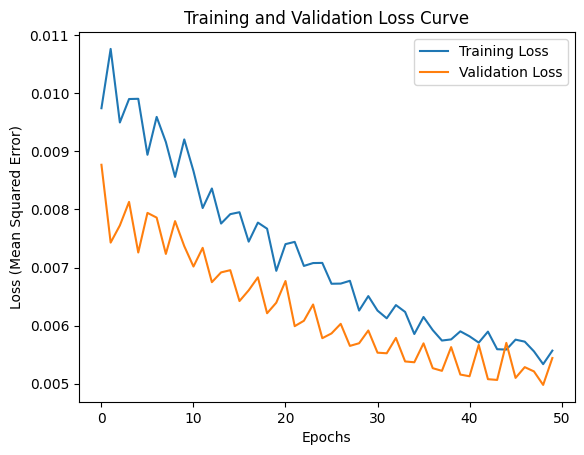

In [49]:
# Train the model
num_epochs = 50
# Initialize lists to store training and validation losses
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass on training data
    outputs = model(X_train_tensor)
    train_loss = criterion(outputs, y_train_tensor)

    # Backward pass and optimization
    train_loss.backward()
    optimizer.step()

    # Store training loss
    train_losses.append(train_loss.item())

    # Evaluate on validation data
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor)  # Validation loss
        val_losses.append(val_loss.item())

    # Print results every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Validation Loss: {val_loss.item():.4f}")

# Plot training and validation loss
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (Mean Squared Error)")  # Update loss unit description
plt.title("Training and Test Loss Curve")
plt.legend()
plt.show()

In [50]:
# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f"Test Loss: {test_loss.item():.4f}")


Test Loss: 0.0054


In [32]:
# Inverse transform the test labels
y_test_original = scaler_y.inverse_transform(y_test_tensor.cpu().numpy())

In [33]:
# Inverse transform the predicted values
y_pred_original = scaler_y.inverse_transform(y_pred.cpu().numpy())

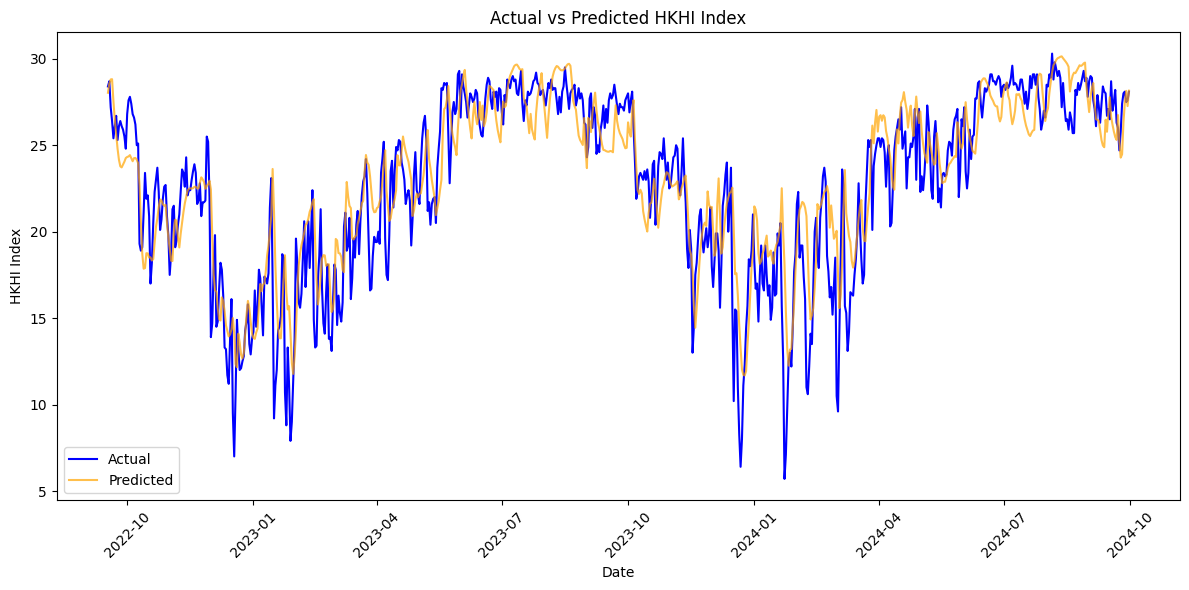

In [34]:
# Extract datetime values for the test data
# Assuming `kings_park_data` contains the original dataset with 'Year', 'Month', and 'Day'.
test_dates = kings_park_data.iloc[-len(y_test_original):]['Date']


# Plot actual vs predicted with datetime on the x-axis
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_original, label="Actual", color="blue")
plt.plot(test_dates, y_pred_original, label="Predicted", color="orange", alpha=0.7)

plt.xlabel("Date")
plt.ylabel("HKHI Index")
plt.title("Actual vs Predicted HKHI Index")
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

Predict Other regions

In [35]:
other_regions_data = df[df['WeatherStationName_en'] != "King's Park"]

In [36]:
other_regions_data = other_regions_data.sort_values(by='Date', ascending=False)


In [37]:
latest_7_days_by_region = (
    other_regions_data.groupby('WeatherStationName_en')
    .head(7)  # Get the top 7 rows for each group (region)
    .sort_values(by=['WeatherStationName_en', 'Date'])  # Optional: Re-sort the result by region and date
)

In [38]:
latest_7_days_by_region

,WeatherStationName_en,Value_Humidity,Value_Temperature,Value_Wind_Speed,Value_Wind_Direction,Value_Heat_Index,Date
143530,Cheung Chau,51.0,25.2,32.2,350.0,NaN,2024-10-25
143544,Cheung Chau,74.0,25.5,31.0,20.0,NaN,2024-10-26
143558,Cheung Chau,82.0,26.7,21.0,60.0,NaN,2024-10-27
143572,Cheung Chau,76.0,24.7,22.5,360.0,NaN,2024-10-28
143586,Cheung Chau,80.0,24.1,14.5,360.0,NaN,2024-10-29
...,...,...,...,...,...,...,...
143571,Wong Chuk Hang,75.0,27.3,10.1,70.0,NaN,2024-10-27
143585,Wong Chuk Hang,68.0,26.1,7.7,60.0,NaN,2024-10-28
143599,Wong Chuk Hang,70.0,25.3,5.4,60.0,NaN,2024-10-29
143613,Wong Chuk Hang,69.0,25.7,4.1,110.0,NaN,2024-10-30


In [39]:
# Initialize an empty list to store predictions
predictions = []

# Group by region
for region, group in latest_7_days_by_region.groupby('WeatherStationName_en'):
    # Select features and scale
    X_latest = group[features].values
    X_latest_scaled = scaler_X.transform(X_latest)

    # Prepare the input sequence
    X_latest_sequence = X_latest_scaled.reshape(1, seq_length, len(features))  # Shape: (1, 7, num_features)
    X_latest_tensor = torch.tensor(X_latest_sequence, dtype=torch.float32).to(device)

    # Predict the next day's HKHI index
    model.eval()
    with torch.no_grad():
        next_day_prediction = model(X_latest_tensor)

    # Inverse transform the prediction
    next_day_prediction_original_scale = scaler_y.inverse_transform(next_day_prediction.cpu().numpy())

    # Get the latest date in this region's data
    latest_date = group['Date'].max()

    # Calculate the prediction date (next day)
    predicted_date = pd.to_datetime(latest_date) + pd.Timedelta(days=1)

    # Save the prediction, region, and predicted date
    predictions.append({
        'Region': region,
        'Predicted_Date': predicted_date.strftime('%Y-%m-%d'),
        'Predicted_HKHI_Index': next_day_prediction_original_scale[0][0]
    })

In [63]:
# Filter the latest King's Park data
kings_park_latest = df.query("WeatherStationName_en == 'King\\'s Park'") \
                      .sort_values(by='Date', ascending=False).head(1)

# Prepare the King's Park prediction as a DataFrame
kings_park_prediction_df = pd.DataFrame([{
    'Region': "King's Park",
    'Predicted_Date': predictions[-1]['Predicted_Date'],  # Use the predicted date
    'HKHI_Index': predictions[-1]['Predicted_HKHI_Index']  # Use the predicted HKHI index
}])

# Rename columns in the predictions DataFrame to match the desired output format
predictions_df = predictions_df.rename(columns={
    'Predicted_HKHI_Index': 'HKHI_Index'
})

# Concatenate the predictions DataFrame with King's Park prediction
final_df = pd.concat([predictions_df, kings_park_prediction_df], ignore_index=True)

# Select only the relevant columns
final_df = final_df[['Region', 'Predicted_Date', 'HKHI_Index']]

final_df.head(20)

,Region,Predicted_Date,HKHI_Index
0,Cheung Chau,2024-11-01,29.348841
1,Hong Kong International Airport,2024-11-01,23.669291
2,Lau Fau Shan,2024-11-01,26.865053
3,Peng Chau,2024-11-01,29.057558
4,Sai Kung,2024-11-01,23.568445
5,Sha Tin,2024-11-01,24.343630
6,Shek Kong,2024-11-01,22.991364
7,Ta Kwu Ling,2024-11-01,22.846611
8,Tseung Kwan O,2024-11-01,24.261101
9,Tuen Mun,2024-11-01,23.204565


In [64]:
final_df.to_csv('FACT_FINAL.csv', index=False)

In [41]:
# Save the trained model
torch.save(model.state_dict(), "lstm_model.pth")

# Load the model
model.load_state_dict(torch.load("lstm_model.pth"))
model.eval()

<ipython-input-41-7320b04e4a18>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("lstm_model.pth"))


ImprovedLSTMModel(
  (lstm): LSTM(4, 128, num_layers=3, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)